## 分分钟杀入Kaggle TOP5% 系列（2）

In [171]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#离散化的数据进行编号
from sklearn.preprocessing import LabelEncoder
#分割 训练和测试集
from sklearn.model_selection import train_test_split
#导入逻辑斯蒂回归
from sklearn.linear_model import LogisticRegression
#特征分解
from sklearn.svm import SVC, LinearSVC
#随机森林分类树
from sklearn.ensemble import RandomForestClassifier
#KNN聚类
from sklearn.neighbors import KNeighborsClassifier
#高斯
from sklearn.naive_bayes import GaussianNB
#感知机
from sklearn.linear_model import Perceptron
##
from sklearn.linear_model import SGDClassifier
#决策树分类器
from sklearn.tree import DecisionTreeClassifier
##梯度下降分类器
from sklearn.ensemble import GradientBoostingClassifier
#网格搜索、交叉验证分数、类似K折交叉切分、学习曲线
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
#xgboost分类器
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [172]:
#os.chdir('/Users/zhouzhirui/Documents/evilpsycho/zhihu/kaggle/titanic/data/')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine_df = pd.concat([train_df,test_df])

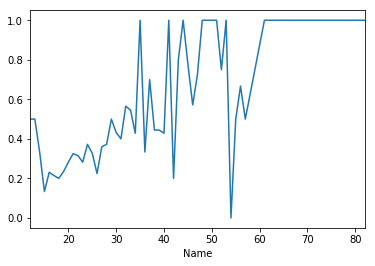

In [173]:
train_df.groupby(train_df.Name.apply(lambda x: len(x)))['Survived'].mean().plot()

<img style="float: center;" src="2.jpg" width="40%">

In [174]:
combine_df['Name_Len'] = combine_df['Name'].apply(lambda x: len(x)) 
combine_df['Name_Len'] = pd.qcut(combine_df['Name_Len'],5)

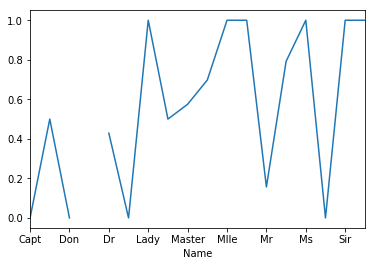

In [175]:
combine_df.groupby(combine_df['Name'].apply(lambda x: x.split(', ')[1]).apply(lambda x: x.split('.')[0]))['Survived'].mean().plot()

<img style="float: center;" src="1.jpg" width="40%">

In [176]:
combine_df['Title'] = combine_df['Name'].apply(lambda x: x.split(', ')[1]).apply(lambda x: x.split('.')[0]) 
combine_df['Title'] = combine_df['Title'].replace(['Don','Dona', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col','Sir','Dr'],'Mr') 
combine_df['Title'] = combine_df['Title'].replace(['Mlle','Ms'], 'Miss') 
combine_df['Title'] = combine_df['Title'].replace(['the Countess','Mme','Lady','Dr'], 'Mrs') 
df = pd.get_dummies(combine_df['Title'],prefix='Title')
combine_df = pd.concat([combine_df,df],axis=1)


Mme：称呼非英语民族的"上层社会"已婚妇女,及有职业的妇女，相当于Mrs
Jonkheer:乡绅
Capt：船长？。。
Lady：贵族夫人的称呼
Don唐：是西班牙语中贵族和有地位者的尊称
sir：都懂
the Countess：女伯爵
Ms：Ms.或Mz 美国近来用来称呼婚姻状态不明的妇女
Col：中校:Lieutenant Colonel(Lt. Col.)上校:Colonel(Col.)
Major：少校
Mlle:小姐
Rev：牧师
测试集合中特殊的Dona：女士尊称

In [177]:
combine_df['Surname'] = combine_df['Name'].apply(lambda x:x.split(',')[0]) 
dead_female_surname = list(set(combine_df[(combine_df.Sex=='female') & (combine_df.Age>=12) & (combine_df.Survived==0) & ((combine_df.Parch>0) | (combine_df.SibSp > 0))]['Surname'].values)) 
survive_male_surname = list(set(combine_df[(combine_df.Sex=='male') & (combine_df.Age>=12) & (combine_df.Survived==1) & ((combine_df.Parch>0) | (combine_df.SibSp > 0))]['Surname'].values)) 
combine_df['Dead_female_family'] = np.where(combine_df['Surname'].isin(dead_female_surname),0,1) 
combine_df['Survive_male_family'] = np.where(combine_df['Surname'].isin(survive_male_surname),0,1) 
combine_df = combine_df.drop(['Name','Surname'],axis=1)


在泰坦尼克场景下，女性死亡和男性存活都是小概率事件，模型会很容易判断女性乘客存活、男性乘客死亡，为了提升模型对于这一类群体的识别能力，我们分析数据找到了一个重要特征，family，同一个family下的生存死亡模式有很大程度上是相同的，例如：有一个family有一个女性死亡，这个family其他的女性的死亡概率也比较高。

In [178]:
group = combine_df.groupby(['Title', 'Pclass'])['Age'] 
combine_df['Age'] = group.transform(lambda x: x.fillna(x.median())) 
combine_df = combine_df.drop('Title',axis=1)
combine_df['IsChild'] = np.where(combine_df['Age']<=12,1,0) 
combine_df['Age'] = pd.cut(combine_df['Age'],5) 
combine_df = combine_df.drop('Age',axis=1) 


采用和第一期同样的方法，添加一个小孩子标签

In [179]:
combine_df['Familysize'] = combine_df.SibSp + combine_df.Parch 
combine_df['Familysize'] = np.where(combine_df['Familysize']==0, 'solo', np.where(combine_df['Familysize']<=3, 'normal', 'big')) 
df = pd.get_dummies(combine_df['Familysize'],prefix='Familysize') 
combine_df = combine_df.drop(['SibSp','Parch','Familysize'],axis=1)

我们将上面提取过的Familysize再离散化

In [180]:
combine_df['Ticket_Lett'] = combine_df['Ticket'].apply(lambda x: str(x)[0]) 
combine_df['Ticket_Lett'] = combine_df['Ticket_Lett'].apply(lambda x: str(x))
combine_df['High_Survival_Ticket'] = np.where(combine_df['Ticket_Lett'].isin(['1', '2', 'P']),1,0) 
combine_df['Low_Survival_Ticket'] = np.where(combine_df['Ticket_Lett'].isin(['A','W','3','7']),1,0) 
combine_df = combine_df.drop(['Ticket','Ticket_Lett'],axis=1)

In [181]:
combine_df.Embarked = combine_df.Embarked.fillna('S') 
df = pd.get_dummies(combine_df['Embarked'],prefix='Embarked') 
combine_df = pd.concat([combine_df,df],axis=1).drop('Embarked',axis=1)

In [182]:
combine_df['Cabin_isNull'] = np.where(combine_df['Cabin'].isnull(),0,1) 
combine_df = combine_df.drop('Cabin',axis=1)

In [183]:
df = pd.get_dummies(combine_df['Pclass'],prefix='Pclass') 
combine_df = pd.concat([combine_df,df],axis=1).drop('Pclass',axis=1)

In [184]:
df = pd.get_dummies(combine_df['Sex'],prefix='Sex') 
combine_df = pd.concat([combine_df,df],axis=1).drop('Sex',axis=1)


In [185]:
# combine_df['Fare'] = pd.qcut(combine_df['Fare'],3) 
# df = pd.get_dummies(combine_df['Fare'],prefix='Fare').drop('Fare_(-0.001, 8.662]',axis=1) 
# combine_df = pd.concat([combine_df,df],axis=1).drop('Fare',axis=1)

所有特征转化成数值型编码

In [186]:
#Fare
combine_df['Fare'].fillna(combine_df['Fare'].dropna().median(),inplace=True)
combine_df['Low_Fare'] = np.where(combine_df['Fare']<=8.662,1,0)
combine_df['High_Fare'] = np.where(combine_df['Fare']>=26,1,0)
combine_df = combine_df.drop('Fare',axis=1)

所有特征转化成数值型编码

In [187]:
features = combine_df.drop(["PassengerId","Survived"], axis=1).columns
le = LabelEncoder()
for feature in features:
    le = le.fit(combine_df[feature])
    combine_df[feature] = le.transform(combine_df[feature])

得到训练/测试数据

In [188]:
X_all = combine_df.iloc[:891,:].drop(["PassengerId","Survived"], axis=1)
Y_all = combine_df.iloc[:891,:]["Survived"]
X_test = combine_df.iloc[891:,:].drop(["PassengerId","Survived"], axis=1)

分别考察逻辑回归、支持向量机、最近邻、决策树、随机森林、gbdt、xgbGBDT几类算法的性能。

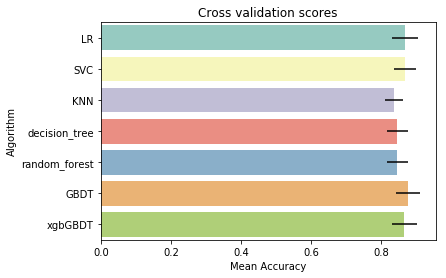

In [189]:
logreg = LogisticRegression()
svc = SVC()
knn = KNeighborsClassifier(n_neighbors = 3)
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier(n_estimators=300,min_samples_leaf=4,class_weight={0:0.745,1:0.255})
gbdt = GradientBoostingClassifier(n_estimators=500,learning_rate=0.03,max_depth=3)
xgb = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.03)
clfs = [logreg, svc, knn, decision_tree, random_forest, gbdt, xgb]

kfold = 10
cv_results = []
for classifier in clfs :
    #kfold-10折交叉，n_jobs表示使用的cpu数目
    cv_results.append(cross_val_score(classifier, X_all.values, y = Y_all.values, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

ag = ["LR","SVC",'KNN','decision_tree',"random_forest","GBDT","xgbGBDT"]
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm":ag})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [190]:
for i in range(7):
    print(ag[i],cv_means[i])

LR 0.8696961184882535
SVC 0.8696961184882535
KNN 0.8383225513562591
decision_tree 0.8472613778231756
random_forest 0.8474372942912269
GBDT 0.8775990239473386
xgbGBDT 0.8674614118715243


In [191]:
from sklearn.metrics import precision_score

class Bagging(object):
    
    def __init__(self,estimators):
        self.estimator_names = []
        self.estimators = []
        for i in estimators:
            self.estimator_names.append(i[0])
            self.estimators.append(i[1])
        self.clf = LogisticRegression()
    
    def fit(self, train_x, train_y):
        for i in self.estimators:
            i.fit(train_x,train_y)
        x = np.array([i.predict(train_x) for i in self.estimators]).T
        y = train_y
        self.clf.fit(x, y)
    
    def predict(self,x):
        x = np.array([i.predict(x) for i in self.estimators]).T
        #print(x)
        return self.clf.predict(x)
        
    
    def score(self,x,y):
        s = precision_score(y,self.predict(x))
        #print(s)
        return s

In [192]:
lr = LogisticRegression()
rf = RandomForestClassifier(n_estimators=300,min_samples_leaf=4,class_weight={0:0.745,1:0.255})
gbdt = GradientBoostingClassifier(n_estimators=500,learning_rate=0.03,max_depth=3)
xgbGBDT = XGBClassifier(max_depth=3, n_estimators=500, learning_rate=0.03)
clfs = [logreg, svc, knn, decision_tree, random_forest, gbdt, xgb]

bag = Bagging([('xgb',xgb),('lr',lr),('gbdt',gbdt),('rf',rf)])

from sklearn.metrics import precision_score

In [193]:
score = 0
for i in range(0,10):
    num_test = 0.20
    #分割数据集
    X_train, X_cv, Y_train, Y_cv = train_test_split(X_all.values, Y_all.values, test_size=num_test)
    bag.fit(X_train, Y_train)
    #Y_test = bag.predict(X_test)
    acc_xgb = round(bag.score(X_cv, Y_cv) * 100, 2)
    score+=acc_xgb
score/10

83.74600000000001

In [194]:
bag.fit(X_all.values, Y_all.values)
Y_test = bag.predict(X_test.values).astype(int)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_test
    })
submission.to_csv(r'submission.csv', index=False)